In [4]:
import dill
import nltk
import torch
import pymorphy3
import pandas as pd
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score, accuracy_score
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
model = SentenceTransformer("cointegrated/rubert-tiny")

sentences = [
    "Привет, как дела?",
    "Здравствуйте, как вы поживаете?"
]

embeddings = model.encode(sentences)

# один раз скачать стоп-слова
nltk.download("stopwords")
# Скачаем русские токенизаторы
nltk.download("punkt")
nltk.download("punkt_tab")

# Инициализируем морфоанализатор
morph = pymorphy3.MorphAnalyzer()
stop_words = set(stopwords.words("russian")) - {'не', 'ну', 'вот'}

def preprocess(text):
    # токенизация (только слова, без пунктуации)
    tokens = word_tokenize(text, language="russian")
    # лемматизация + удаление стоп-слов и чисел
    sep_tokens = {".", "?", "!", "..."}
    lemmas = []
    for token in tokens:
        if token in sep_tokens:
            lemmas.append("<SEP>")
        elif token.isalpha() and token not in stop_words:
            lemmas.append(morph.parse(token)[0].normal_form)

    return " ".join(lemmas)
df = pd.read_csv('m18_jokes_dataset.csv')
df_2ch = pd.read_csv('data.tsv', sep='\t', index_col=0)

df['anekdot'] = df['text'].apply(preprocess)
df_2ch['message'] = df_2ch['message'].apply(preprocess)
df.drop(['text'], axis=1, inplace=True)

df = df[~df['anekdot'].isna()]
df = df[df['anekdot'].str.strip() != ""]
df_2ch = df_2ch[~df_2ch['message'].isna()]
df_2ch = df_2ch[df_2ch['message'].str.strip() != ""]
df_2ch = df_2ch['message']
#df['anekdot'].isna().sum(), (df['anekdot'].str.strip() == "").sum()

le = LabelEncoder()
df['temi'] = le.fit_transform(df['theme'])
classes = {idx:clas for idx,clas in enumerate(le.classes_)}
df.drop(['theme'],axis=1, inplace=True)

X = model.encode(df['anekdot'].tolist())
xtr1, xte1, ytr1, yte1 = train_test_split(X, df['temi'], stratify=df['temi'], test_size=.1, random_state=42, shuffle=True)
xtr, xte, ytr, yte = train_test_split(df['anekdot'], df['temi'], test_size=.1, random_state=42, stratify=df['temi'], shuffle=True)
df_2ch = pd.concat([df_2ch, xtr])

def new_vocab(xtr):
    vocab_list = []
    vocab_list.extend([x for text in xtr for x in text.split() if x != "<SEP>"])
    vocab_list = ["<PAD>", "<UNK>", "<SEP>"] + list(dict.fromkeys(vocab_list))  # set() не сохраняет порядок, при случае пересборки словаря все поломается, а так норм
    vocab = {word: idx for idx, word in enumerate(vocab_list)}
    print(len(vocab_list))
    return vocab

vocab = new_vocab(xtr)
vocab_with_2ch = new_vocab(df_2ch)

with open('anek_vocab.pkl', 'wb') as file:
    dill.dump(vocab, file)

with open('anek_2ch_vocab.pkl', 'wb') as file:
    dill.dump(vocab_with_2ch, file)

sents_tr = [x.split() for x in xtr.tolist()]
sents_te = [x.split() for x in xte.tolist()]

indices_tr = [[vocab.get(word, vocab["<UNK>"]) for word in sent] for sent in sents_tr]
indices_te = [[vocab.get(word, vocab["<UNK>"]) for word in sent] for sent in sents_te]

length_tr = [len(sent.split()) for sent in xtr.to_list()]
q99 = int(pd.DataFrame(length_tr).quantile(0.99))

indices_tr_q99 = [sent[:q99] for sent in indices_tr if len(sent) > 0]
indices_te_q99 = [sent[:q99] for sent in indices_te if len(sent) > 0]

seqs_tr = [torch.tensor(seq) for seq in indices_tr_q99]
seqs_te = [torch.tensor(seq) for seq in indices_te_q99]

padded_tr = pad_sequence(seqs_tr, batch_first=True, padding_value=vocab["<PAD>"])
padded_te = pad_sequence(seqs_te, batch_first=True, padding_value=vocab["<PAD>"])

xtr_tensor = torch.tensor(xtr1, dtype=torch.float32)
ytr_tensor = torch.tensor(ytr1.values, dtype=torch.long)

xte_tensor = torch.tensor(xte1, dtype=torch.float32)
yte_tensor = torch.tensor(yte1.values, dtype=torch.long)

# attention_mask: 1 для токена, 0 для паддинга
tr_mask = (padded_tr != 0).long()
te_mask = (padded_te != 0).long()

train_set = TensorDataset(xtr_tensor, ytr_tensor)
test_set = TensorDataset(xte_tensor, yte_tensor)

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = DataLoader(test_set, batch_size=100)

train_set2 = TensorDataset(padded_tr, tr_mask, ytr_tensor)
test_set2 = TensorDataset(padded_te, te_mask, yte_tensor)

train_loader2 = DataLoader(train_set2, batch_size=100)
test_loader2 = DataLoader(test_set2, batch_size=100)

No sentence-transformers model found with name cointegrated/rubert-tiny. Creating a new one with mean pooling.
[nltk_data] Downloading package stopwords to C:\Users\wa-
[nltk_data]     Arakelyan_P\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\wa-
[nltk_data]     Arakelyan_P\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\wa-
[nltk_data]     Arakelyan_P\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


32983
298648


C:\Users\wa-Arakelyan_P\AppData\Local\Temp\ipykernel_9872\3867885863.py:81: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  q99 = int(pd.DataFrame(length_tr).quantile(0.99))


In [5]:
import torch.nn as nn

class TransformerBlock(nn.Module):
    def __init__(self, embed, hidden, num_heads=2):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed, num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(embed)
        self.norm2 = nn.LayerNorm(embed)
        self.ff = nn.Sequential(
            nn.Linear(embed, hidden),
            nn.ReLU(),
            nn.Linear(hidden, embed)
        )
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.3)

    def forward(self, x, mask=None):
        # MultiheadAttention принимает key_padding_mask (True = игнорировать токен!)
        attn_out, _ = self.attn(x, x, x, key_padding_mask=~mask.bool() if mask is not None else None)
        x = self.norm1(x + self.dropout1(attn_out))
        x = self.norm2(x + self.dropout1(self.ff(x)))
        return x

class Transformer_Max(nn.Module):
    def __init__(self, vocab_size, embed=128, num_classes=17, hidden=1024, num_heads=2, num_layers=2, max_len=500):
        super().__init__()
        self.tokens = nn.Embedding(vocab_size, embed)
        self.poses = nn.Embedding(max_len, embed)
        self.transes = nn.ModuleList([
            TransformerBlock(embed, hidden, num_heads) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embed, num_classes)

    def forward(self, x, mask=None):
        batch, seq_len = x.shape
        pos = torch.arange(0, seq_len, dtype=torch.long, device = x.device).unsqueeze(0).expand_as(x)
        x = self.tokens(x) + self.poses(pos)

        # маскируем паддинги
        mask_with_cls = None if mask is None else mask

        # Пропускаем через блоки
        for trans in self.transes:
            x = trans(x, mask=None if mask is None else mask_with_cls)

        x, _ = x.max(dim=1)
        return self.fc(x)

class Transformer(nn.Module):
    def __init__(self, vocab_size, embed=128, num_classes=17, hidden=1024, num_heads=2, num_layers=2, max_len=500):
        super().__init__()
        self.tokens = nn.Embedding(vocab_size+1, embed)
        self.poses = nn.Embedding(max_len+1, embed)
        self.transes = nn.ModuleList([
            TransformerBlock(embed, hidden, num_heads) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embed, num_classes)
        self.cls = vocab_size

    def forward(self, x, mask=None):
        batch, seq_len = x.shape
        clses = torch.full((batch, 1), self.cls, dtype=torch.long, device=x.device)
        x = torch.cat((clses, x), dim=1)
        pos = torch.arange(0, seq_len+1, dtype=torch.long, device=x.device).unsqueeze(0).expand_as(x)
        x = self.tokens(x) + self.poses(pos)

        # маскируем паддинги
        mask_with_cls = None if mask is None else torch.cat([torch.ones((batch,1), device=x.device), mask], dim=1)

        # Пропускаем через блоки
        for trans in self.transes:
            x = trans(x, mask=None if mask is None else mask_with_cls)

        CLS = x[:, 0, :]
        return self.fc(CLS)

import dill

class Transformer_mix(nn.Module):
    def __init__(self, vocab_size, embed=512, num_classes=17, hidden=1024, num_heads=16, num_layers=3, max_len=500, path_to_vocab=None, q99=120, classes=None, max_segments=100):
        super().__init__()
        self.tokens = nn.Embedding(vocab_size+1, embed)
        self.poses = nn.Embedding(max_len+1, embed)
        self.segments = nn.Embedding(max_segments, embed)
        self.transes = nn.ModuleList(
            TransformerBlock(embed, hidden, num_heads) for _ in range(num_layers)
        )
        self.fc = nn.Sequential(
            nn.Linear(embed*3, embed*6),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(embed*6, num_classes)
        )
        self.cls = vocab_size
        self.q99 = q99
        self.vocab = dill.load(open(path_to_vocab, "rb"))
        self.sep_id = self.vocab['<SEP>']
        self.classes = classes

    def predict(self, text, device):
        # Индексы токенов
        indices_tr = [self.vocab.get(word, self.vocab["<UNK>"]) for word in text.split()]
        indices_tr_q99 = indices_tr[:q99]  # обрезка до q99
        # Паддинг
        pad_len = q99 - len(indices_tr_q99)
        indices_tr_q99 = indices_tr_q99 + [self.vocab["<PAD>"]] * pad_len
        # Маска: 1 = реальный токен, 0 = паддинг
        mask = [1] * (len(indices_tr[:q99])) + [0] * pad_len #indices_tr хранит предложения без падинга, так что по его длине максируем [1] и [0] падинги, но отсекаем по q99, если длинный попался
        # В тензоры
        x = torch.tensor(indices_tr_q99, dtype=torch.long).unsqueeze(0).to(device)  # (1, q99)
        mask = torch.tensor(mask, dtype=torch.long).unsqueeze(0).to(device)       # (1, q99)
        # Предсказание
        with torch.no_grad():
            logits = self.forward(x, mask)
            pred = torch.argmax(logits, dim=1).item()
        print(classes[pred])
        return pred

    def forward(self, x, mask=None, return_hidden=False):
        batch, seq = x.shape
        clses = torch.full((batch, 1), self.cls, dtype=torch.long, device=x.device)
        x = torch.cat([clses, x], dim=1)

        pos = torch.arange(0, seq+1, device=x.device).unsqueeze(0).expand(batch, -1)
        # сегменты (находим <SEP>, делаем cumsum)
        #sep_mask = (x == self.sep_id).int()       # где стоят <SEP>, будет 1
        #segments = sep_mask.cumsum(dim=1) % 2 # нумерация сегментов (0,1,2,...) кумулятивной суммой, то есть при каждом попадании единицы будет +1 к сумме, далее значения будут на 1 больше
        #segments = segments.clamp(max=self.segments.num_embeddings - 1) #модель рассчитана на 10 предложений, такой передан параметр, поэтому все предложения после 9 будут иметь индекс 9

        # складываем эмбеддинги
        #x = self.tokens(x) + self.poses(pos) + self.segments(segments)
        x = self.tokens(x) + self.poses(pos)
        # маскируем паддинги
        mask_with_cls = None if mask is None else torch.cat([torch.ones((batch,1), device=x.device), mask], dim=1)

        # Пропускаем через блоки
        for trans in self.transes:
            x = trans(x, mask=None if mask is None else mask_with_cls)
            
        if return_hidden:
            return x[:, 1:, :]
        
        if mask is not None:
            x_masked = x[:,1:,:] * mask.unsqueeze(-1)   # обнуляем паддинги
            mean_pooling = x_masked.sum(1) / mask.sum(1, keepdim=True).clamp(min=1)
            x_masked_for_max = x[:, 1:, :].masked_fill(mask.unsqueeze(-1) == 0, -1e9) #шумы, прошедшие через модель, по сути фейки, нельзя, чтобы выбрались как максимум вместо реальных данных
            max_pooling, _ = x_masked_for_max.max(1)
        else:
            mean_pooling = x[:,1:,:].mean(1)
            max_pooling, _ = x[:,1:,:].max(1)

        CLS = x[:,0,:]
        out = torch.cat([CLS, mean_pooling, max_pooling], dim=1)
        return self.fc(out)

class Classificator(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        x = self.ff(x)
        return x

from sklearn.metrics import f1_score, accuracy_score

def train(model, model_name:str, optimizer, loss_fn, train_loader, test_loader, scheduler, epochs, device):
    model, loss_fn = model.to(device), loss_fn.to(device)
    losses, f1s, accs = [], [], []
    best_acc, idx, best_idx = 0, 0, 0
    for epoch in range(epochs):
        model.train()
        for x, mask, y in train_loader:
            x, mask, y = x.to(device), mask.to(device), y.to(device, dtype=torch.long)
            pred = model(x, mask)

            loss = loss_fn(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        f1, acc, val_loss = validate(model, loss_fn, test_loader, device)
        model.train()
        scheduler.step(val_loss)

        f1s.append(f1)
        accs.append(acc)
        losses.append(val_loss)
        idx += 1
        if acc>best_acc:
          torch.save(model.state_dict(), f'weights_{model_name}.pt')
          best_acc = acc
          best_idx = idx
          print(f"✅ Saved new best model to {f'weights_{model_name}.pt'}")
        print(f"Epoch {epoch+1}/{epochs} | loss={val_loss:.4f}, f1={f1:.4f}, acc={acc:.4f}")
    print(f'best_epoch {best_idx} with acc {best_acc}')
    return losses, f1s, accs


def validate(model, loss_fn, test_loader, device):
    model.eval()
    y_true, y_pred = [], []
    loss_sum, total = 0, 0

    with torch.no_grad():
        for x, mask, y in test_loader:
            x, mask, y = x.to(device), mask.to(device), y.to(device, dtype=torch.long)
            pred = model(x, mask)

            loss = loss_fn(pred, y)
            loss_sum += loss.item()

            preds = pred.argmax(dim=1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(y.cpu().numpy())
            total += y.size(0)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    return f1, acc, loss_sum / len(test_loader)


In [17]:
model_class = Classificator(312, 624, 17)


device = 'cuda' 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_class.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer)
epochs = 100
losses, f1s, accs = train(model_class, 'classificator', optimizer, loss_fn, train_loader, test_loader, scheduler, epochs, device)

✅ Saved new best model to weights.pt
Epoch 1/100 | loss=2.0995, f1=0.3014, acc=0.3453
✅ Saved new best model to weights.pt
Epoch 2/100 | loss=1.9724, f1=0.3559, acc=0.3888
✅ Saved new best model to weights.pt
Epoch 3/100 | loss=1.9297, f1=0.3919, acc=0.4100
✅ Saved new best model to weights.pt
Epoch 4/100 | loss=1.8881, f1=0.3955, acc=0.4229
✅ Saved new best model to weights.pt
Epoch 5/100 | loss=1.8579, f1=0.4009, acc=0.4253
✅ Saved new best model to weights.pt
Epoch 6/100 | loss=1.8618, f1=0.4019, acc=0.4282
✅ Saved new best model to weights.pt
Epoch 7/100 | loss=1.8232, f1=0.4221, acc=0.4376
Epoch 8/100 | loss=1.8478, f1=0.4014, acc=0.4329
Epoch 9/100 | loss=1.8232, f1=0.4093, acc=0.4353
✅ Saved new best model to weights.pt
Epoch 10/100 | loss=1.7879, f1=0.4348, acc=0.4494
Epoch 11/100 | loss=1.8362, f1=0.4070, acc=0.4376
✅ Saved new best model to weights.pt
Epoch 12/100 | loss=1.8033, f1=0.4382, acc=0.4535
Epoch 13/100 | loss=1.7909, f1=0.4300, acc=0.4524
Epoch 14/100 | loss=1.7992

Результат 0.4965 по accuracy в 17 эпохе. Не слишком достойно. Модель rubert-tiny не обучалась понимать юмор, поэтому понятно

In [20]:
anek = ['Черчилль спрашивает Сталина что бы вы с вашей армией сделали с Гитлером, будь он у вас в руках? Сталин отвечает раскалил бы кочергу докрасна и засунул бы холодным концом ему в задницу. -А почему холодным, товарищ Сталин? -Чтобы вы, господин Черчилль, не помогли ему ее вытащить',
'Приходит пациент к доктору и говорит: доктор, хуй чешется. Доктор отвечает: мой чаще. -Нет, мой',
"— Вовочка, ты почему не сделал домашнее задание? — А я в шахматы играл с папой.",
"Доктор сказал, что я ленивый. Хотелось бы узнать, с чего он это взял — я даже анализы не сдал.",
"Жена попросила что-то починить дома, и теперь у нас две поломки вместо одной.",
"Студент выучил весь билет, кроме одного вопроса. И именно его спросили. Карма любит точность.",
"Когда я говорю «пять минут и выхожу», это значит «через двадцать, и то не факт».",
"Если долго смотреть на холодильник, он начнёт казаться источником решений всех жизненных проблем.",
"Алкоголь не решает проблемы, но вода тоже не помогает, проверено.",
"Мой кот уверен, что работает начальником — я его кормлю, убираю и слушаю недовольное мяуканье.",
"В армии поняли, что я не умею стрелять, и дали метлу — теперь я подметаю прицельно.",
"У школьников память феноменальная — особенно когда речь идёт о том, кто кому что сказал три года назад.",
"Медсестра сказала не переживать перед уколом. Теперь переживаю, почему она это сказала с улыбкой."
]

def predict_classificator(text):
    model_class.to('cpu')
    logits = model_class(torch.tensor(model.encode(text), dtype=torch.float32))
    print(classes[torch.argmax(logits).item()])

for i in anek: 
    predict_classificator(i)

pro-studentov
meditsinskie
pro-studentov
pro-studentov
pro-studentov
tsitati
pro-studentov
aforizmi
aforizmi
pro-studentov
narodnie
shkolnie-i-pro-shkolu
pro-evreev


In [21]:
device = 'cuda'
model_class_mix = Transformer_mix(len(vocab), q99=120, path_to_vocab='anek_vocab.pkl')
loss_fn4 = nn.CrossEntropyLoss()
optimizer4 = torch.optim.Adam(model_class_mix.parameters(), lr=1e-5, weight_decay=1e-5) #L2 регуляризация
scheduler4 = ReduceLROnPlateau(optimizer4)
epochs = 35
losses4, f1s4, accs4 = train(model_class_mix, 'mix', optimizer4, loss_fn4, train_loader2, test_loader2, scheduler4, epochs, device)

✅ Saved new best model to weights_mix.pt
Epoch 1/35 | loss=2.6594, f1=0.1461, acc=0.1888
✅ Saved new best model to weights_mix.pt
Epoch 2/35 | loss=2.4738, f1=0.2161, acc=0.2606
✅ Saved new best model to weights_mix.pt
Epoch 3/35 | loss=2.1604, f1=0.3254, acc=0.3500
✅ Saved new best model to weights_mix.pt
Epoch 4/35 | loss=1.9567, f1=0.3858, acc=0.4100
✅ Saved new best model to weights_mix.pt
Epoch 5/35 | loss=1.8421, f1=0.4137, acc=0.4424
✅ Saved new best model to weights_mix.pt
Epoch 6/35 | loss=1.7607, f1=0.4323, acc=0.4612
✅ Saved new best model to weights_mix.pt
Epoch 7/35 | loss=1.7042, f1=0.4501, acc=0.4800
✅ Saved new best model to weights_mix.pt
Epoch 8/35 | loss=1.6664, f1=0.4769, acc=0.5006
✅ Saved new best model to weights_mix.pt
Epoch 9/35 | loss=1.6341, f1=0.4921, acc=0.5129
✅ Saved new best model to weights_mix.pt
Epoch 10/35 | loss=1.6104, f1=0.5036, acc=0.5235
✅ Saved new best model to weights_mix.pt
Epoch 11/35 | loss=1.5903, f1=0.5181, acc=0.5347
✅ Saved new best mo

Результат 0.5594 по accuracy. Модель Transformer_mix обучалась понимать юмор, в ней объединены эмбеддинги обученного CLS токена, усреднение и поиск максимальной активации в каждом токене, поэтому результат лучше

In [13]:
anek = 'Черчилль спрашивает Сталина что бы вы сделали с Гитлером, будь он у вас в руках? Сталин отвечает раскалил бы кочергу докрасна и засунул бы холодным концом ему в задницу. -А почему холодным, товарищ Сталин? -Чтобы вы, господин Черчилль, не помогли ему ее вытащить'
anek2 = 'Приходит пациент к доктору и говорит: доктор, хуй чешется. Доктор отвечает: мой чаще. -Нет, мой'
anek3 = "— Вовочка, ты почему не сделал домашнее задание? — А я в шахматы играл с папой."
model_class_mix.predict(anek3, device)

aforizmi


0

In [22]:
model_class_max = Transformer_Max(len(vocab))
loss_fn2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model_class_max.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler2 = ReduceLROnPlateau(optimizer2)
epochs = 45
losses2, f1s2, accs2 = train(model_class_max, 'max', optimizer2, loss_fn2, train_loader2, test_loader2, scheduler2, epochs, device)

✅ Saved new best model to weights_max.pt
Epoch 1/45 | loss=2.6511, f1=0.1388, acc=0.1853
✅ Saved new best model to weights_max.pt
Epoch 2/45 | loss=2.3981, f1=0.2459, acc=0.2876
✅ Saved new best model to weights_max.pt
Epoch 3/45 | loss=2.0557, f1=0.3457, acc=0.3729
✅ Saved new best model to weights_max.pt
Epoch 4/45 | loss=1.9107, f1=0.4026, acc=0.4300
✅ Saved new best model to weights_max.pt
Epoch 5/45 | loss=1.8307, f1=0.4361, acc=0.4582
✅ Saved new best model to weights_max.pt
Epoch 6/45 | loss=1.7617, f1=0.4582, acc=0.4818
✅ Saved new best model to weights_max.pt
Epoch 7/45 | loss=1.7070, f1=0.4806, acc=0.5012
✅ Saved new best model to weights_max.pt
Epoch 8/45 | loss=1.6684, f1=0.4899, acc=0.5082
✅ Saved new best model to weights_max.pt
Epoch 9/45 | loss=1.6411, f1=0.4970, acc=0.5147
✅ Saved new best model to weights_max.pt
Epoch 10/45 | loss=1.6234, f1=0.5028, acc=0.5218
✅ Saved new best model to weights_max.pt
Epoch 11/45 | loss=1.6195, f1=0.5140, acc=0.5324
Epoch 12/45 | loss=

Результат 0.5400 по accuracy в 18 эпохе. Модель Transformer_max обучалась понимать юмор, в ней результат - поиск максимальной активации в каждом токене

In [23]:
model_class_cls = Transformer(len(vocab))
loss_fn3 = nn.CrossEntropyLoss()
optimizer3 = torch.optim.Adam(model_class_cls.parameters(), lr=1e-4, weight_decay=1e-5) #L2 регуляризация
scheduler3 = ReduceLROnPlateau(optimizer3)
epochs = 35
losses3, f1s3, accs3 = train(model_class_cls, 'cls', optimizer3, loss_fn3, train_loader2, test_loader2, scheduler3, epochs, device)

✅ Saved new best model to weights_cls.pt
Epoch 1/35 | loss=2.2567, f1=0.2430, acc=0.2671
✅ Saved new best model to weights_cls.pt
Epoch 2/35 | loss=1.9963, f1=0.3566, acc=0.3782
✅ Saved new best model to weights_cls.pt
Epoch 3/35 | loss=1.8847, f1=0.4113, acc=0.4276
✅ Saved new best model to weights_cls.pt
Epoch 4/35 | loss=1.7792, f1=0.4508, acc=0.4659
✅ Saved new best model to weights_cls.pt
Epoch 5/35 | loss=1.7249, f1=0.4650, acc=0.4794
✅ Saved new best model to weights_cls.pt
Epoch 6/35 | loss=1.6919, f1=0.4809, acc=0.4947
✅ Saved new best model to weights_cls.pt
Epoch 7/35 | loss=1.6597, f1=0.4939, acc=0.5053
✅ Saved new best model to weights_cls.pt
Epoch 8/35 | loss=1.6398, f1=0.5065, acc=0.5176
✅ Saved new best model to weights_cls.pt
Epoch 9/35 | loss=1.6352, f1=0.5149, acc=0.5259
✅ Saved new best model to weights_cls.pt
Epoch 10/35 | loss=1.6161, f1=0.5256, acc=0.5365
✅ Saved new best model to weights_cls.pt
Epoch 11/35 | loss=1.6209, f1=0.5248, acc=0.5371
✅ Saved new best mo

Результат 0.5459 по accuracy в 16 эпохе. Модель Transformer обучалась понимать юмор, в ней результат обученный токен CLS последовательности

In [ ]:
def predict2(text, model1, device="cuda"):
    # Индексы токенов
    indices_tr = [vocab.get(word, vocab["<UNK>"]) for word in text.split()]
    indices_tr_q99 = indices_tr[:q99]  # обрезка до q99
    # Паддинг
    pad_len = q99 - len(indices_tr_q99)
    indices_tr_q99 = indices_tr_q99 + [vocab["<PAD>"]] * pad_len
    # Маска: 1 = реальный токен, 0 = паддинг
    mask = [1] * (len(indices_tr[:q99])) + [0] * pad_len #+1 для cls токена
    print(len(indices_tr[:q99]), q99, indices_tr, indices_tr_q99)
    # В тензоры
    x = torch.tensor(indices_tr_q99, dtype=torch.long).unsqueeze(0).to(device)  # (1, q99)
    mask = torch.tensor(mask, dtype=torch.long).unsqueeze(0).to(device)        # (1, q99)
    # Предсказание
    model1.eval()
    with torch.no_grad():
        logits = model1(x, mask)
        pred = torch.argmax(logits, dim=1).item()
    print(classes[pred])
    return pred

In [ ]:
predict2(anek3, model_class_cls)

In [ ]:
predict2(anek, model_class_max)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch

# 1. Загружаем данные
df = pd.read_csv("m18_jokes_dataset.csv")

# Убираем пустые строки
df = df[~df['text'].isna()]
df = df[df['text'].str.strip() != ""]

# Кодируем лейблы в int
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["labels"] = le.fit_transform(df["theme"])

# 2. Делим train/test через sklearn со стратификацией
train_idx, test_idx = train_test_split(
    list(range(len(df))),
    test_size=0.2,
    stratify=df["labels"],
    random_state=42
)

train_dataset = Dataset.from_pandas(df.iloc[train_idx])
test_dataset = Dataset.from_pandas(df.iloc[test_idx])

# 3. Загружаем токенизатор и модель
MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# HuggingFace Trainer требует правильные колонки
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(le.classes_))

# 4. Настройки обучения
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_strategy="epoch",        # сохраняем раз в эпоху
    eval_strategy="epoch",  # валидируем раз в эпоху (нужно обновить версию transformers >=4.20)
    load_best_model_at_end=True,
    do_eval=True
)

# 5. Метрики
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1": f1}

# 6. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# 7. Запуск обучения
trainer.train()

Map:   0%|          | 0/13598 [00:00<?, ? examples/s]

Map:   0%|          | 0/3400 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.005000,0.994749,0.712647,0.699541
2,0.716200,0.804988,0.764412,0.759786
3,0.515200,0.833427,0.773529,0.775308
4,0.274600,0.923489,0.779118,0.777912
5,0.158700,1.166228,0.769118,0.777167
6,0.117900,1.294375,0.766471,0.769447


TrainOutput(global_step=5100, training_loss=0.5684604077011931, metrics={'train_runtime': 476.4897, 'train_samples_per_second': 171.227, 'train_steps_per_second': 10.703, 'total_flos': 5367398974479360.0, 'train_loss': 0.5684604077011931, 'epoch': 6.0})

In [4]:
trainer.save_model("./results")
tokenizer.save_pretrained("./results")

('./results\\tokenizer_config.json',
 './results\\special_tokens_map.json',
 './results\\vocab.txt',
 './results\\added_tokens.json')

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

# 1. Загружаем данные
df = pd.read_csv("m18_jokes_dataset.csv")

# Убираем пустые строки
df = df[~df['text'].isna()]
df = df[df['text'].str.strip() != ""]

# Кодируем лейблы в int
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["labels"] = le.fit_transform(df["theme"])

# 2. Делим train/test через sklearn со стратификацией
train_idx, test_idx = train_test_split(
    list(range(len(df))),
    test_size=0.2,
    stratify=df["labels"],
    random_state=42
)

train_dataset = Dataset.from_pandas(df.iloc[train_idx])
test_dataset = Dataset.from_pandas(df.iloc[test_idx])

# 3. Загружаем токенизатор и модель
MODEL_NAME = "./final_robert_model"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# HuggingFace Trainer требует правильные колонки
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(le.classes_))

# 4. Настройки обучения
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_strategy="epoch",        # сохраняем раз в эпоху
    eval_strategy="epoch",  # валидируем раз в эпоху (нужно обновить версию transformers >=4.20)
    load_best_model_at_end=True,
    do_eval=True
)

# 5. Метрики
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1": f1}

# 6. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.evaluate(test_dataset)

Map:   0%|          | 0/13598 [00:00<?, ? examples/s]

Map:   0%|          | 0/3400 [00:00<?, ? examples/s]

{'eval_loss': 0.7241831421852112,
 'eval_model_preparation_time': 0.0,
 'eval_accuracy': 0.8476470588235294,
 'eval_f1': 0.8467183538961977,
 'eval_runtime': 12.6417,
 'eval_samples_per_second': 268.952,
 'eval_steps_per_second': 16.849}

In [3]:
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=1)
true_labels = predictions.label_ids

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(true_labels, pred_labels, target_names=le.classes_))

                       precision    recall  f1-score   support

             aforizmi       1.00      0.99      0.99       200
         meditsinskie       0.75      0.79      0.77       200
             narodnie       0.76      0.81      0.78       200
   poshlie-i-intimnie       0.69      0.64      0.66       200
      pro-alkogolikov       0.92      0.94      0.93       200
            pro-armiu       0.84      0.86      0.85       200
            pro-detey       0.99      0.96      0.97       200
           pro-evreev       0.92      0.95      0.94       200
        pro-militsiyu       0.97      0.88      0.92       200
          pro-mugchin       0.76      0.79      0.77       200
    pro-novih-russkih       0.89      0.93      0.91       200
            pro-semyu       0.72      0.72      0.72       200
        pro-studentov       0.82      0.83      0.83       200
         pro-vovochku       0.95      0.93      0.94       200
               raznie       0.52      0.48      0.50  

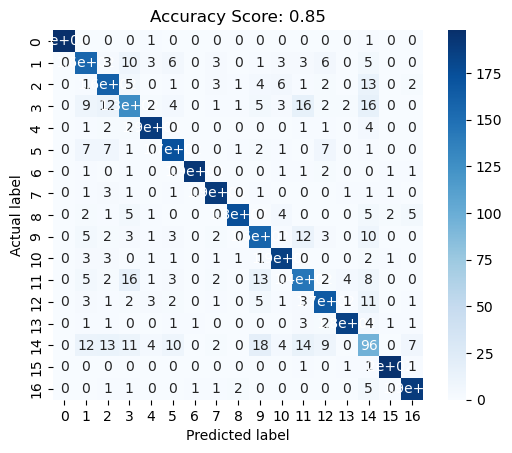

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

acc = accuracy_score(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure()
sns.heatmap(cm, annot=True, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Accuracy Score: {acc:.2f}')

plt.show()

In [ ]:
from transformers import Trainer, TrainingArguments
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch

# 1. Загружаем данные
df = pd.read_csv("m18_jokes_dataset.csv")

# Убираем пустые строки
df = df[~df['text'].isna()]
df = df[df['text'].str.strip() != ""]

# Кодируем лейблы в int
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["labels"] = le.fit_transform(df["theme"])

# 2. Делим train/test через sklearn со стратификацией
train_idx, test_idx = train_test_split(
    list(range(len(df))),
    test_size=0.2,
    stratify=df["labels"],
    random_state=42
)

train_dataset = Dataset.from_pandas(df.iloc[train_idx])
test_dataset = Dataset.from_pandas(df.iloc[test_idx])

# 3. Загружаем токенизатор и модель
MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# HuggingFace Trainer требует правильные колонки
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(le.classes_))

# 4. Настройки обучения (совместимо со старыми версиями transformers)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_steps=1000,          # просто периодически сохраняем по шагам
    save_total_limit=2,       # храним не больше N чекпоинтов
    report_to="none"
)

# 5. Метрики (как у тебя)
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1": f1}

# 6. Trainer (eval_dataset можно передать — он пригодится для trainer.evaluate())
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# 7. Обучение + отдельная валидация
trainer.train()
metrics = trainer.evaluate()   # считаем метрики после обучения
print(metrics)

# (опционально) сохранить модель и токенизатор
trainer.save_model("./results/best")
tokenizer.save_pretrained("./results/best")

In [ ]:
def predict(texts, model, tokenizer, label_encoder, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    texts: список строк (анекдотов)
    model: обученный BertForSequenceClassification
    tokenizer: BertTokenizer
    label_encoder: твой LabelEncoder (для обратного преобразования)
    """
    model.eval()
    model.to(device)

    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

    decoded_preds = label_encoder.inverse_transform(preds)
    return decoded_preds

texts = [
    "Приходит Вовочка в школу без домашки.",
    "Заходит мужик в бар и видит там медведя."
]

preds = predict(texts, model, tokenizer, le)
for t, p in zip(texts, preds):
    print(f"Текст: {t}\nТема: {p}\n")

In [6]:
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

if '<MASK>' not in vocab_with_2ch:
    vocab_with_2ch['<MASK>'] = len(vocab_with_2ch)
mask_id = vocab_with_2ch['<MASK>']
pad_id = vocab_with_2ch['<PAD>']
sep_id = vocab_with_2ch['<SEP>']
cls_id = len(vocab_with_2ch)

def mask_tokens(batch_ids, mask_prob=0.15):
    """
    На вход подаётся батч индексов (batch_size, seq_len)
    Возвращает:
      - masked: тот же тензор, где 15% токенов заменены на <MASK>
      - labels: тот же тензор, но все НЕзамаскированные позиции = -100 (игнорируются в CrossEntropyLoss)
    """
    device = batch_ids.device     # берём устройство входного батча
    masked = batch_ids.clone()    # копия входов
    labels = batch_ids.clone()    # копия входов для обучения
    rand = torch.rand(batch_ids.shape, device=device)    # равномерное распределение [0,1)
    # приводим идентификаторы к тензорам на том же устройстве
    pad_t = torch.tensor(pad_id, device=device)
    cls_t = torch.tensor(cls_id, device=device)
    sep_t = torch.tensor(sep_id, device=device)

    # Выбираем токены, которые заменим на MASK (15%)
    mask_arr = (rand < mask_prob) & (batch_ids != pad_t) & (batch_ids != cls_t) & (batch_ids != sep_t)
    
    # Заменяем выбранные токены на <MASK>
    masked[mask_arr] = mask_id

    # Все не замаскированные метки делаем -100 (чтобы не учитывались в loss)
    labels[~mask_arr] = -100

    return masked, labels  # форма (batch_size, seq_len)

# Формируем корпус для самопредобучения: анекдоты + 2ch
texts_unsup = pd.concat([df_2ch, df['anekdot']]).drop_duplicates().tolist()

# Замена на индексы
tokenized_unsup = [[vocab_with_2ch.get(token, vocab_with_2ch['<UNK>']) for token in text.split()]for text in texts_unsup]

# Обрезание до q99 и тензоризация
lengths = [len(sent) for sent in tokenized_unsup]
quantile99 = int(pd.DataFrame(lengths).quantile(0.99))
tokenized_unsup = [torch.tensor(sent[:quantile99]) for sent in tokenized_unsup if len(sent)>0]

# Паддинг до максимальной длины внутри батча
padded_unsup = pad_sequence(tokenized_unsup, batch_first=True, padding_value=pad_id)
# (batch_size, seq_len) — теперь все строки одинаковой длины

# Attention mask: 1 для токенов, 0 для паддингов
mask_unsup = (padded_unsup != pad_id).long()
# (batch_size, seq_len)

# Делаем датасет
unsup_set = TensorDataset(padded_unsup, mask_unsup)
unsup_loader = DataLoader(unsup_set, batch_size=64, shuffle=True)
# В каждом батче:
#   x.shape = (64, seq_len)
#   mask.shape = (64, seq_len)

# Добавляем новую "голову" для MLM. У модели добавится второй выход. Первый так и остается для классификации, второй для восстановления замаскированных токенов

# У модели Transformer_mix выход из self.fc имеет вид (batch_size, num_classes)
# Но нам нужен выход по токенам — для каждого токена предсказать слово.
# Поэтому добавляем линейный слой fc_mlm, который будет восстанавливать исходный токен.
# Его вход — скрытое представление каждого токена (embed_dim), выход — размер словаря (len(vocab)).
model_class_mix2 = Transformer_mix(len(vocab), q99=quantile99, path_to_vocab='anek_vocab.pkl')
embed = model_class_mix2.tokens.embedding_dim
model_class_mix2.fc_mlm = nn.Linear(embed, len(vocab_with_2ch))

for p in model_class_mix2.fc.parameters():
    p.requires_grad = False # замораживаем веса для классификатора, мы обучаем вторую голову

# 🔹 fc[0].in_features // 3 — потому что в модели fc принимает concat из CLS + mean + max
#   (embed * 3), так что одно "ядро" — embed
# Размеры:
#   logits.shape = (batch_size, seq_len, vocab_size)
# теперь модель высчитывает два результата, она годится и для классификации, и для генерации текста, по желанию можно вызвать результат model.fc через model(x), это основной выход, потому что он указан в return, или вернуть model.fc_mlm через ???

mlm_criterion = nn.CrossEntropyLoss(ignore_index=-100)  # не считаем loss на не-масках
optimizer = torch.optim.AdamW(model_class_mix2.parameters(), lr=5e-5)

# Обучение Masked Language Model
epochs = 5
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

def train_mlm(model, loss_fn, optimizer, train_loader, device, epochs):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        total_loss, best_acc, best_epoch = 0, 0, 0
        for x, attn_mask in tqdm(train_loader, desc=f"MLM Epoch {epoch+1}/{epochs}"):
            x, attn_mask = x.to(device), attn_mask.to(device)
            masked_x, labels = mask_tokens(x) # формы: (batch=64, seq_len=q99)
            # Получаем ПОТОКЕНОВЫЕ скрытые признаки (без CLS): (batch, seq, hidden)
            hiddens = model(masked_x, attn_mask, return_hidden=True)
            # Прогоняем через MLM-голову: (batch, seq, hidden)
            logits = model.fc_mlm(hiddens)
            #CrossEntropyLoss требует входы размера (N, C) и (N,).
            #Тут logits имеет форму (batch, seq, vocab_size), а labels — (batch, seq), значит нужно “сплющить”
            loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            # (опционально) считать точность по замаскированным позициям
            with torch.no_grad():
                preds = logits.argmax(dim=-1) 
                mask_pos = labels != -100
                if mask_pos.any(): #защита от ситуации, если не попадется ни одного замаскированного в батче
                    acc = (preds[mask_pos] == labels[mask_pos]).long().sum().item()
                    if acc>best_acc:
                        best_acc = acc
                        best_epoch = epoch
                        torch.save(model.state_dict(), "weights_mlm.pt")
                        print(f"✅ Saved new best model to {f'weights_mlm.pt'}")
        avg_loss = total_loss / len(unsup_loader)
        print(f"Epoch {epoch+1} | MLM loss: {avg_loss:.4f} | masked-acc: {acc:.4f}")
    print(f'Best epoch is {best_epoch} with acc {best_acc}')




NameError: name 'df_2ch' is not defined

In [42]:
torch.cuda.empty_cache()
torch.cuda.synchronize()
train_mlm(model_class_mix2, mlm_criterion, optimizer, unsup_loader, device, epochs)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
